# Cell Wound Repair

## Autogenerated Report: EPIC Cell Wound Repair Analysis
#### Website: https://github.com/AlphonsG/EPIC-BBox-Cell-Tracking

In [1]:
import shutil
import sys
import os
import csv
from copy import deepcopy
from collections import defaultdict
from itertools import chain
import random as rd
from statistics import mean, pstdev

import cv2

from IPython.display import Image, Video

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 

import pandas as pd

import epic
from epic.analysis.cell_migration_analysis import (drnty_vs_euclid_dist,
                                                   metric_box_plots, metric_mthd_avgs,
                                                   smp_trks_le_dist, smp_trks_le_propn, 
                                                   smp_trks_len, traj_plots)
from epic.analysis.cell_migration_metrics import MetricFactory
from epic.utils.cell_migration import detect_leading_edges
from epic.utils.file_processing import (load_imgs, load_motc_dets, load_motc_tracks,
                                        save_imgs, save_motc_tracks, save_video,
                                        video_reshape)
from epic.utils.image_processing import draw_bounding_boxes, draw_leading_edges, draw_tracks
from epic.utils.misc import create_tracklets

In [2]:
# preconfiguration
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
rd.seed(0)
VID_FILENAME = 'video'

In [3]:
# start
cwd = os.getcwd()

## Image Series

In [4]:
# load images
motchallenge_img_dir = os.path.join(cwd, '..', 'img1')
img_dir = (motchallenge_img_dir if os.path.isdir(motchallenge_img_dir) else 
           os.path.join(cwd, '..'))
assert os.path.isdir(img_dir), f'Image directory {img_dir} could not be found.'
imgs = load_imgs(img_dir) 
assert len(imgs) > 1, 'Raw image series shorter than 2 frames.'
print(f'Loaded {len(imgs)} images.')

Loaded 5 images.


In [5]:
for i, img in enumerate(imgs, start=1):
    print(f'Image {i}: {img[0]}')

Image 1: Image_1.png
Image 2: Image_2.png
Image 3: Image_3.png
Image 4: Image_4.png
Image 5: Image_5.png


In [6]:
# show image series
output_dir = os.path.join(cwd, 'Raw_Image_Series')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(imgs, output_dir)
raw_vid = os.path.join(output_dir, VID_FILENAME)
save_video(imgs, raw_vid)
raw_vid +=  epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(raw_vid, 500)
Video(raw_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Cell Detections

In [7]:
# PARAMETER - None OR (> 0 AND <= 1)
dets_min_score = 0.75  # only load detections with this minimum confidence score

In [8]:
# load detections
motc_dets_file = os.path.join(os.getcwd(), '..', epic.DETECTIONS_DIR_NAME, 
                              epic.MOTC_DETS_FILENAME)
assert os.path.isfile(motc_dets_file), f'MOTC detections file {motc_dets_file} could not be found.'
dets = load_motc_dets(motc_dets_file, dets_min_score)
assert len(dets) > 1, 'Detections found in less than 2 frames.'
num_frames = min(len(imgs), len(dets))
imgs, dets = imgs[0: num_frames], dets[0: num_frames]
dets = create_tracklets(dets, imgs)
print(f'Loaded {len(list(chain.from_iterable(list(dets))))} detections.')

Loaded 1244 detections.


In [9]:
# show detections
dets_imgs = deepcopy(imgs)
for ds in dets:
    draw_bounding_boxes(ds, dets_imgs, colour=(0, 0, 255))
output_dir = os.path.join(cwd, 'All_Detections')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(dets_imgs, output_dir)
dets_vid = os.path.join(output_dir, VID_FILENAME)
save_video(dets_imgs, dets_vid)
dets_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(dets_vid, 500)
Video(dets_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Leading Edges

In [10]:
top_le, btm_le = detect_leading_edges(imgs[0][1], dets[0], 2)
print('Detected top and bottom leading edges, in first image '
      f'of series, at y-positions {top_le} and {btm_le} (px.) '
      'respectively.')

Detected top and bottom leading edges, in first image of series, at y-positions 196 and 359 (px.) respectively.


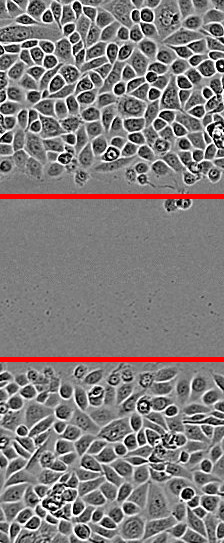

In [11]:
# show leading edges
first_img = imgs[0][1].copy()
draw_leading_edges(first_img, (top_le, btm_le), thickness=4)
cv2.imwrite('leading_edges.png', first_img)
first_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)
Image('leading_edges.png')

## Cell Tracks

In [12]:
# load tracks
motc_tracks_file = os.path.join(os.getcwd(), '..', epic.TRACKS_DIR_NAME, 
                                epic.MOTC_TRACKS_FILENAME)
assert os.path.isfile(motc_tracks_file), f'MOTC tracks file {motc_tracks_file} could not be found.'
auto_tracks = load_motc_tracks(motc_tracks_file)
auto_tracks = create_tracklets(auto_tracks, imgs, method='Automatic')
auto_tracks = list(chain.from_iterable(list(auto_tracks)))
for i, track in enumerate(auto_tracks):
    track.id = i
assert len(auto_tracks) > 0, 'No tracks loaded.'

print(f'Loaded {len(auto_tracks)} tracks.')

Loaded 360 tracks.


In [13]:
track_lens, track_start_frames, track_end_frames = [], [], []
for track in auto_tracks:
    track_lens.append(track.num_dets)
    track_start_frames.append(track.start_frame)
    track_end_frames.append(track.end_frame)
    
print(f'Average length of tracks: {round(mean(track_lens))} frames')
print(f'Average starting frame of tracks: frame {round(mean(track_start_frames))}')
print(f'Average ending frame of tracks: frame {round(mean(track_end_frames))}')

Average length of tracks: 4 frames
Average starting frame of tracks: frame 2
Average ending frame of tracks: frame 4


In [14]:
# show tracks
tracks_imgs = deepcopy(imgs)
draw_tracks(auto_tracks, tracks_imgs)
output_dir = os.path.join(cwd, 'All_Tracks')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(tracks_imgs, output_dir)
tracks_vid = os.path.join(output_dir, VID_FILENAME)
save_video(tracks_imgs, tracks_vid)
tracks_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(tracks_vid, 500)
Video(tracks_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Sampled Cell Tracks

In [15]:
# PARAMETER - 'euclidean_distance' OR 'accumulated_distance' OR 'velocity'
#             OR 'directionality' OR 'y_forward_motion_index' 
#             OR 'endpoint_angle'
# cell migration metrics to compute
metric_names = ['euclidean_distance', 'accumulated_distance', 'velocity',
                'directionality', 'y_forward_motion_index',
                'endpoint_angle']

In [16]:
# automated cell track params
tracks_start_frame = 1
tracks_end_frame = 5
dist_btm_le = 100
dist_top_le = 100
num_btm_le_dets = 10
num_top_le_dets = 10
propn = 0.33

In [17]:
# sample automated cell tracks
print('Sampled Automated Tracks')
rd.shuffle(auto_tracks)
auto_tracks = smp_trks_len(auto_tracks, tracks_end_frame, tracks_start_frame)
assert len(auto_tracks) > 0, 'Could not sample any tracks meeting criteria.'
print('Number of tracks longer than '
      f'{tracks_end_frame - tracks_start_frame} frames: '
      f'{len(auto_tracks)}')
auto_tracks = smp_trks_le_dist(auto_tracks, (top_le, btm_le), dist_btm_le, dist_top_le, 
                               None, None)
# auto_tracks = smp_trks_le_propn(auto_tracks, (top_le, btm_le), propn, img_hgt,
#                                 num_btm_le_dets, num_top_le_dets)
assert len(auto_tracks) > 0, 'Could not sample any tracks meeting criteria.'
print(f'Number of sampled cells: {len(auto_tracks)}')

Sampled Automated Tracks
Number of tracks longer than 4 frames: 160
Number of sampled cells: 82


In [18]:
# visualize sampled automated cell tracks
tracks_imgs = deepcopy(imgs)
draw_tracks(auto_tracks, tracks_imgs)
output_dir = os.path.join(cwd, 'Sampled_Tracks')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(tracks_imgs, output_dir)
tracks_vid = os.path.join(output_dir, VID_FILENAME)
save_video(tracks_imgs, tracks_vid)
tracks_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(tracks_vid, 500)
Video(tracks_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Cell Migration Metrics

In [19]:
# compute automated cell track metrics
m_fcty = MetricFactory()
auto_results = [m_fcty.get_metric(m, 'Automated') for m in metric_names]
img_hgt = imgs[0][1].shape[0]
img_cen_y = imgs[0][1].shape[0] / 2
tracks, results = [], []
for auto_result in auto_results:
    for track in auto_tracks:
        auto_result.compute_metric(track, store=True, first_frame=tracks_start_frame, 
                                   end_frame=tracks_end_frame, img_cen_y=img_cen_y)
tracks.append(auto_tracks)
results.append(auto_results)

In [20]:
# print metrics
for i, rs in enumerate(zip(*results)):
    print(f'Metric: {rs[0].name}')
    for r in rs:
        print(f'{r.method} average: {round(mean(r.stored), 2)} ' 
              f'(SD: {round(pstdev(r.stored), 2)}) {r.units}')
    print()

Metric: Euclidean Distance
Automated average: 17.2 (SD: 10.12) Micrometres (um)

Metric: Accumulated Distance
Automated average: 23.08 (SD: 8.97) Micrometres (um)

Metric: Velocity
Automated average: 8.6 (SD: 5.06) Micrometres/Hour (um/hr)

Metric: Directionality
Automated average: 0.7 (SD: 0.22) Arbitrary Units (AU)

Metric: Y - Forward Motion Index
Automated average: 0.61 (SD: 0.55) Arbitrary Units (AU)

Metric: End Point Angle
Automated average: 107.09 (SD: 60.47) Degrees (Deg)



In [21]:
metrics = {}
metrics['ID'] = [cwd] * len(auto_tracks)
for rs in zip(*results):
    metrics[rs[0].name + ' ' + rs[0].units] = rs[0].stored
df = pd.DataFrame(metrics)
df.to_csv('metrics.csv')

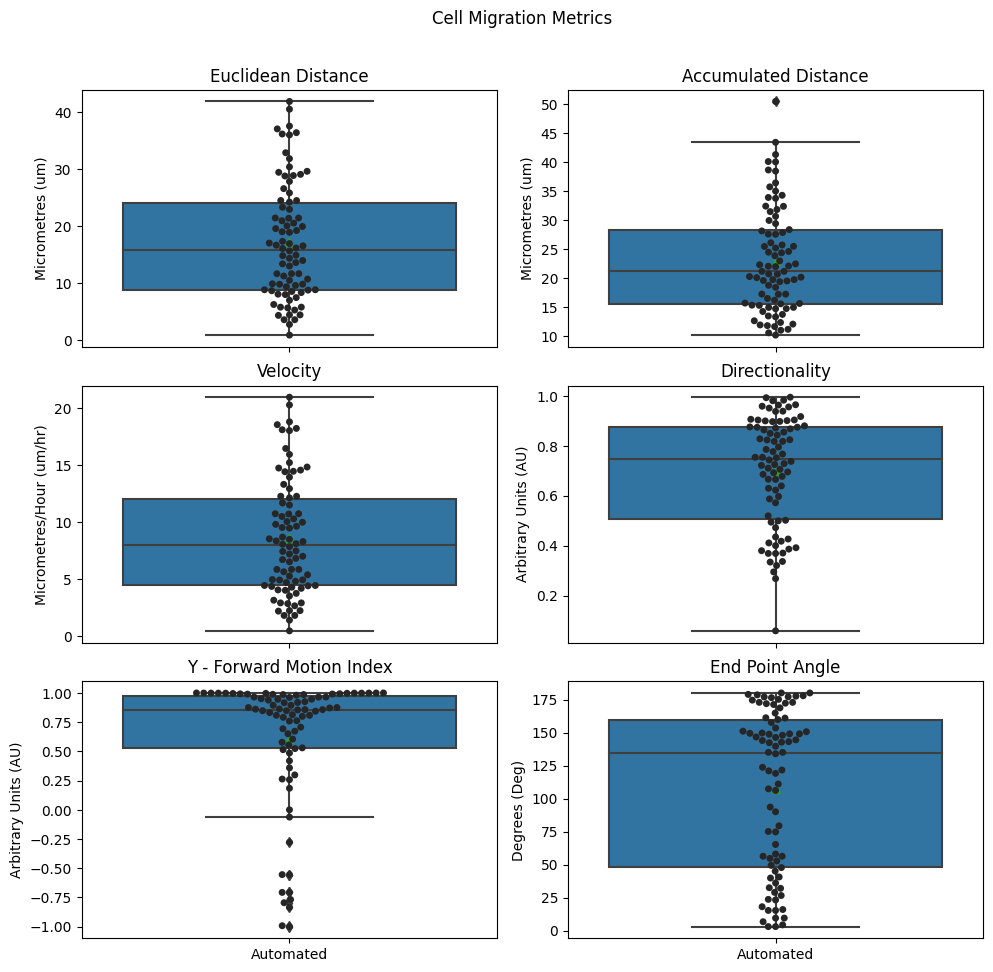

In [22]:
# plots
metric_box_plots(*results)
plt.subplots_adjust(top=0.9)
plt.show()

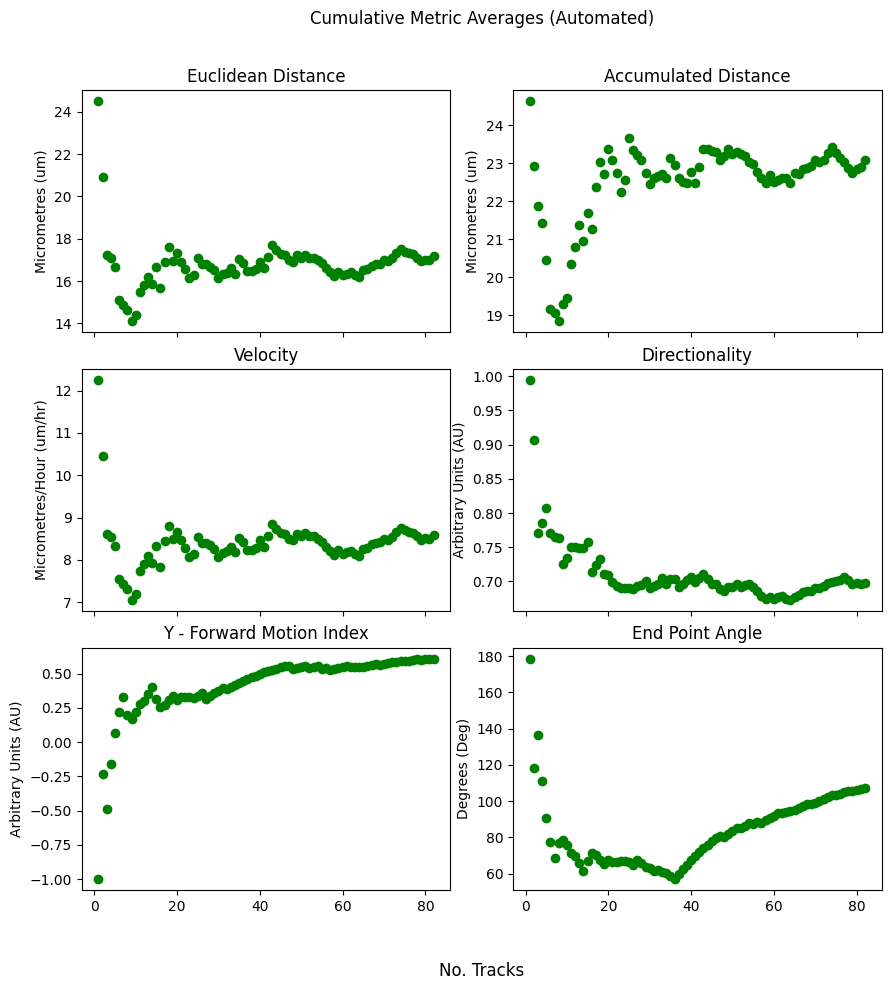

In [23]:
metric_mthd_avgs(*results)
plt.subplots_adjust(top=0.9, right=0.9, bottom=0.1, left=0.1)
plt.show()

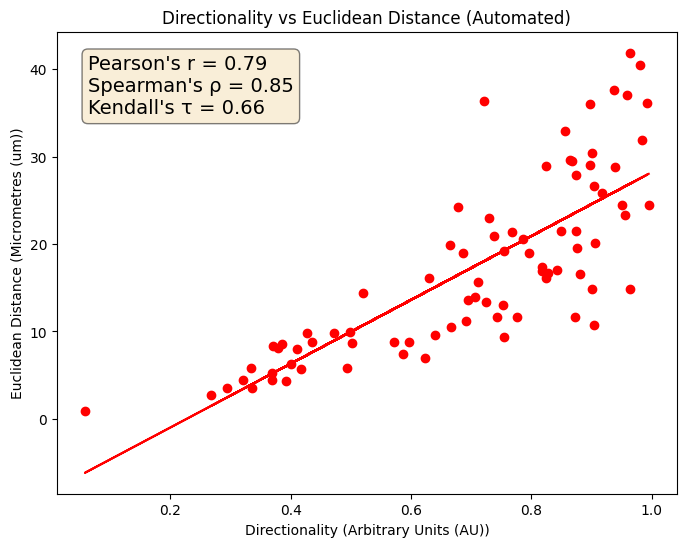

In [24]:
drnty_vs_euclid_dist(*results)
plt.show()

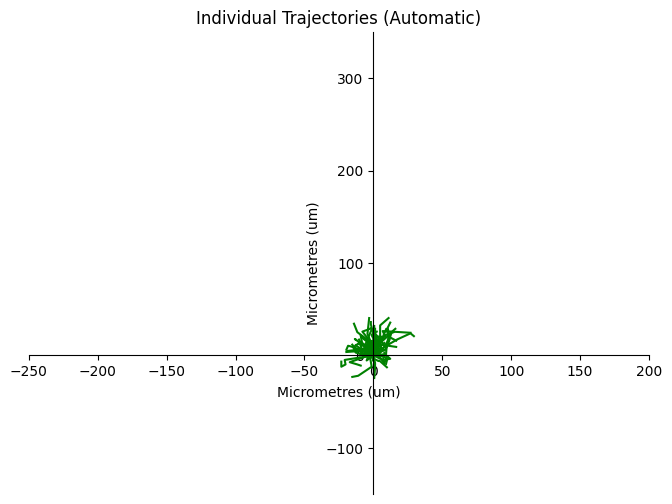

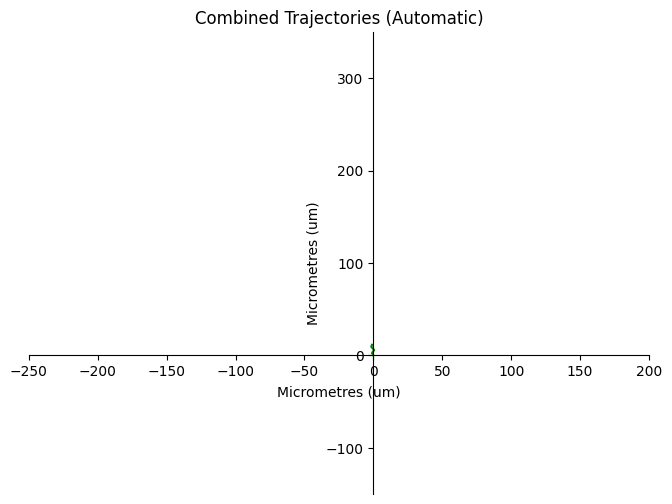

In [25]:
traj_plots(img_cen_y, *tracks, length=None)
plt.show()